# 1. Load Data for CNN

In [1]:
from codes.utils import *
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torchinfo import summary

In [3]:
# load data
num_classes = 50
num_samples_train = 15
num_samples_test = 5
seed = 2022
data_folder = './omniglot_resized'
train_image, train_label, test_image, test_label = LoadData(num_classes, num_samples_train, 
                                                            num_samples_test, seed, data_folder)

In [8]:
import matplotlib.pyplot as plt

plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 
plt.rcParams['figure.figsize'] = (12, 8) 
# plt.style.use("bmh")
# plt.rcParams['font.sans-serif']=['Heiti'] 
plt.rcParams['axes.unicode_minus']=False 
plt.style.use('seaborn-bright')

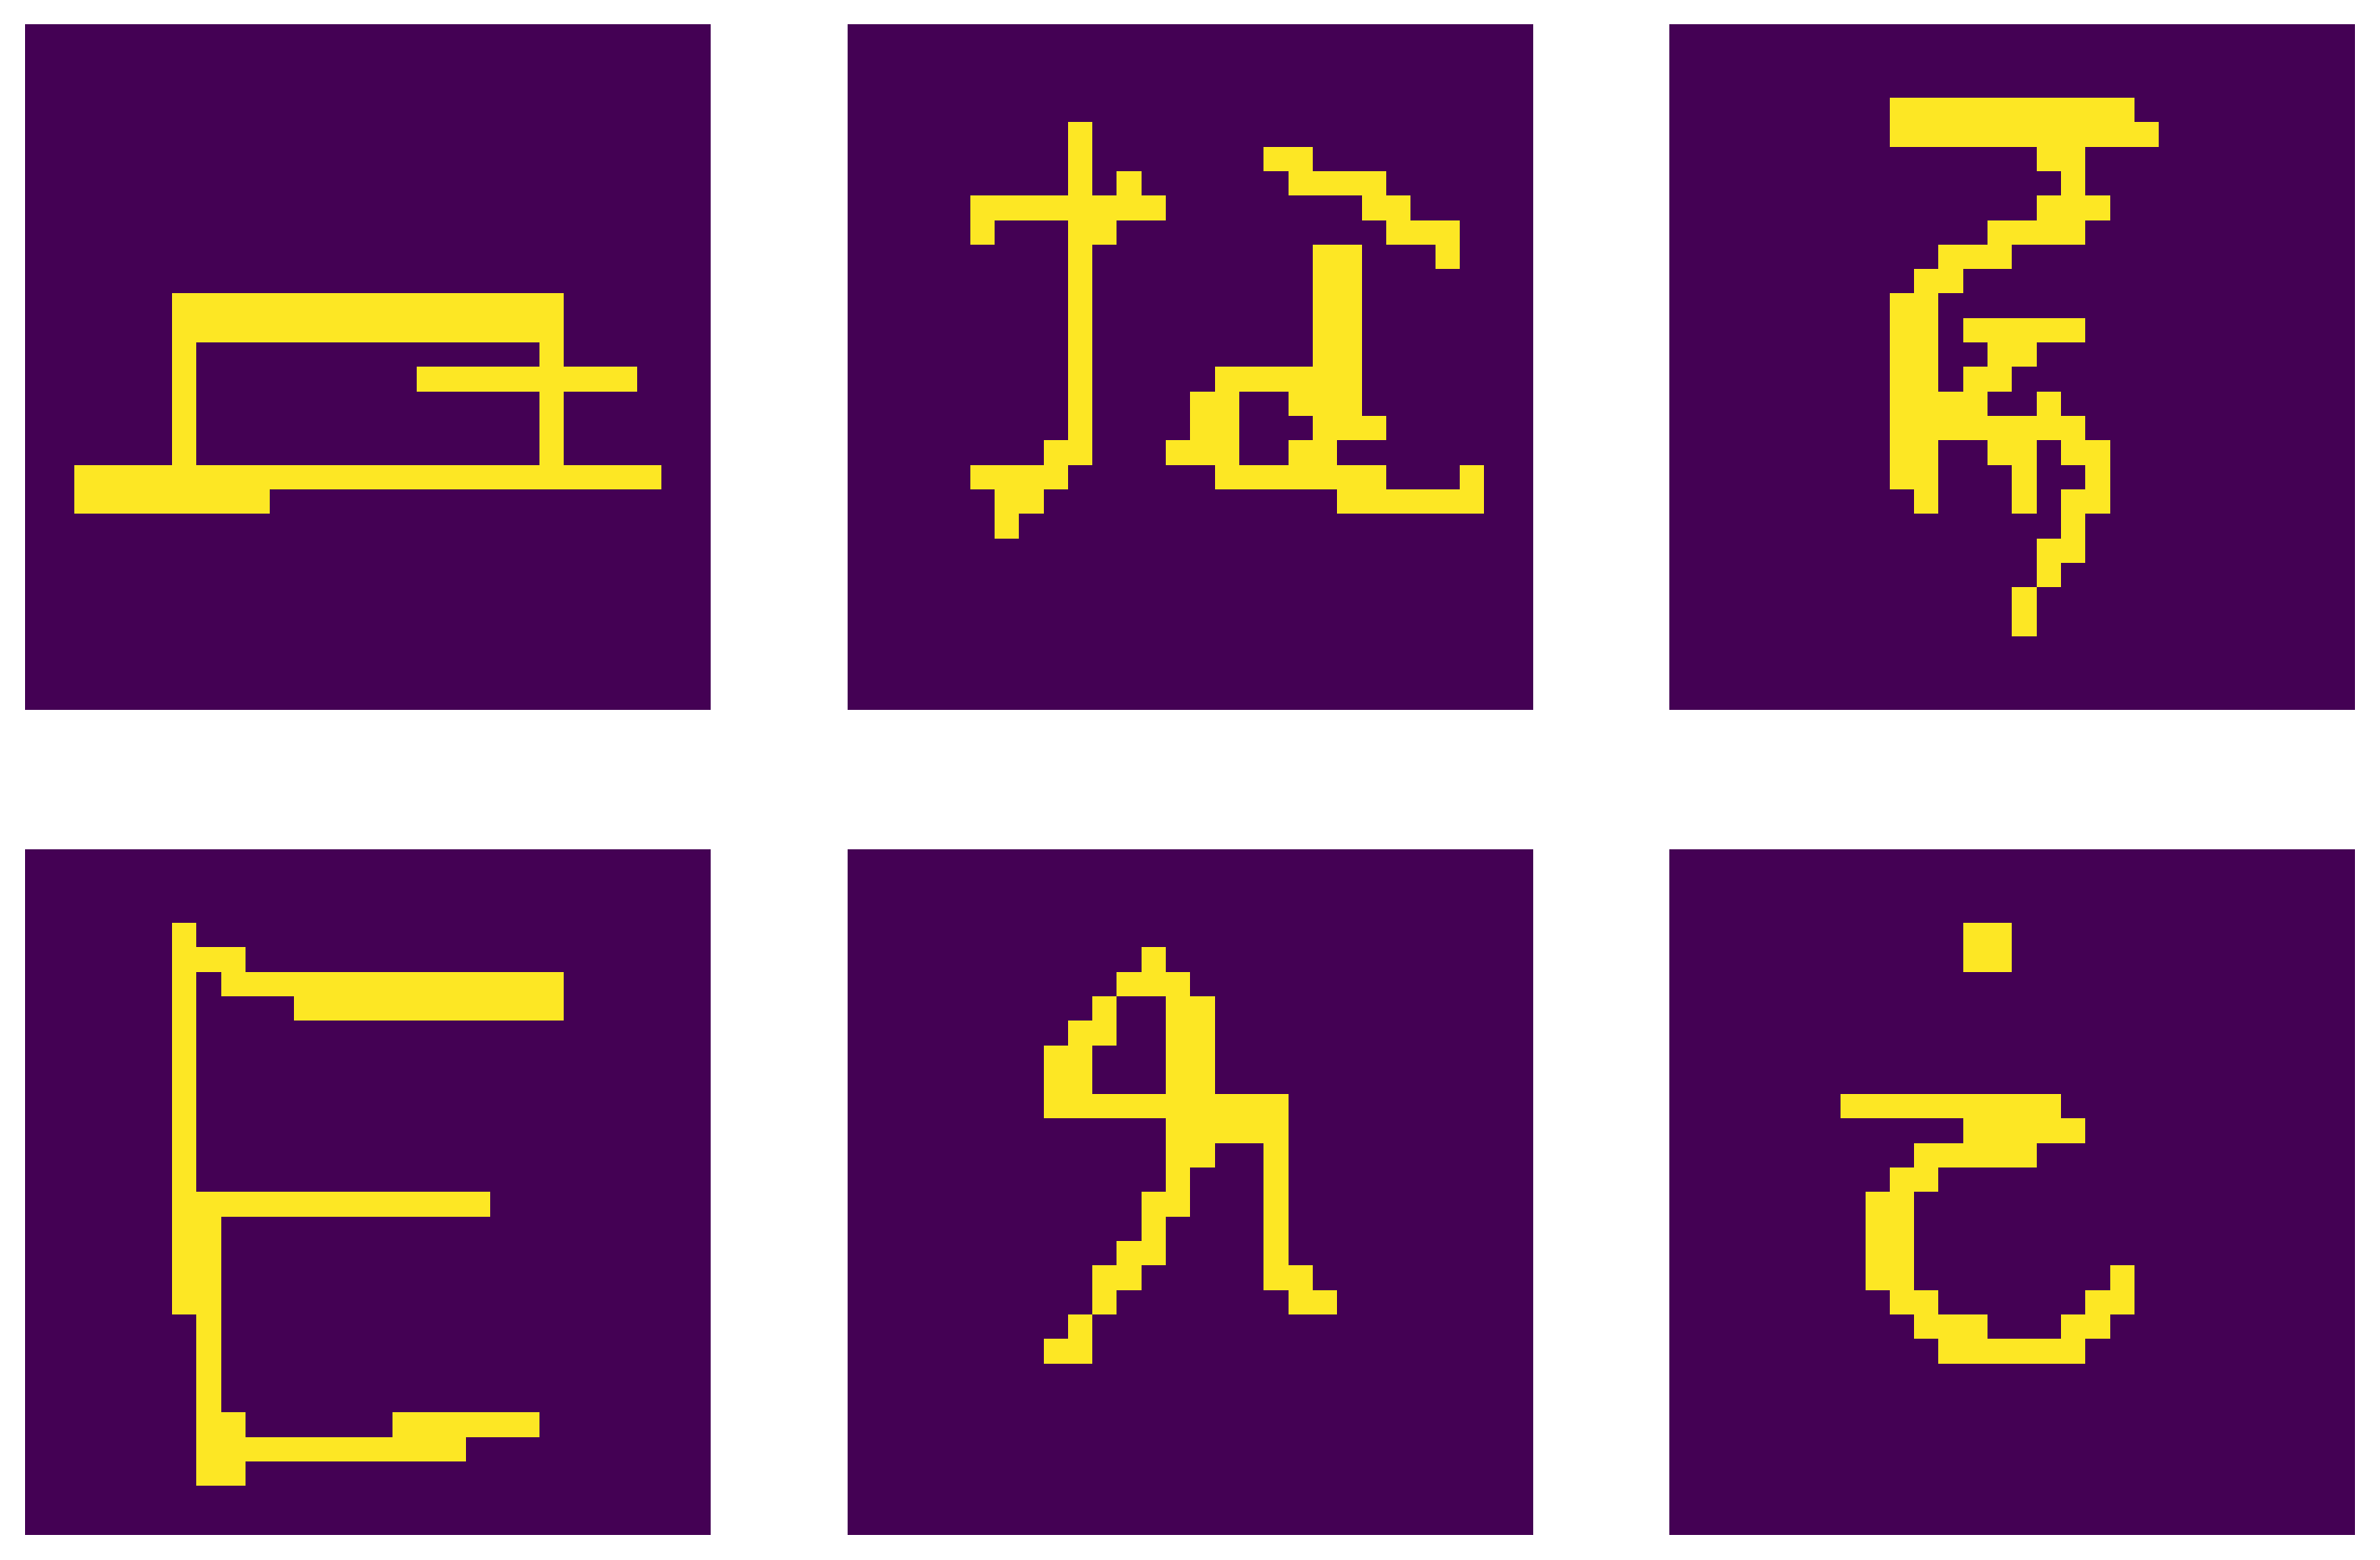

In [9]:
plt.figure(figsize=(12,8))
index = [0,1,2,20,30,50, 70]
for i in range(6):
    plt.imshow(train_image[index[i]].reshape(28,28))
    plt.axis('off')
    plt.subplot(2,3,i+1)
plt.imshow(train_image[index[i+1]].reshape(28,28))
plt.axis('off')
plt.subplot(2,3,i+1)
plt.savefig('data_sample.pdf',  bbox_inches = 'tight')

In [10]:
class ImgDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = torch.FloatTensor(x)
        if y is not None:
            self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [11]:
x_train, x_val, y_train, y_val = train_test_split(train_image, train_label, 
                                                  test_size=0.1, random_state=2022)

batch_size = 128

train_data = ImgDataset(x_train.reshape(-1,1,28,28), y_train)
val_data = ImgDataset(x_val.reshape(-1,1,28,28), y_val)
test_data = ImgDataset(test_image.reshape(-1,1,28,28), test_label)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# 2. Define CNN

In [12]:
class Vanilla_CNN(nn.Module):
    def __init__(self):
        super(Vanilla_CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), # input channel, ouput channel, filter size, stride, padding
            nn.BatchNorm2d(32), # num_features
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # kernel size, stride, padding
        
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512,50),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1) # resize, first axis is batch_num
        return self.fc(out)

# 3. Training

In [13]:
import time
import json
from sklearn.metrics import classification_report
import pandas as pd

In [14]:
vanilla_cnn = Vanilla_CNN()
trainable = sum(p.numel() for p in vanilla_cnn.parameters() if p.requires_grad)
total = sum(param.numel() for param in vanilla_cnn.parameters())
model_para = 'total parameters: {}, trainable parameters: {}'.format(total, trainable)
print(model_para)

total parameters: 1698194, trainable parameters: 1698194


In [15]:
model_info = summary(vanilla_cnn)
model_info

Layer (type:depth-idx)                   Param #
Vanilla_CNN                              --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       9,248
│    └─BatchNorm2d: 2-5                  64
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
│    └─Conv2d: 2-8                       18,496
│    └─BatchNorm2d: 2-9                  128
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      36,928
│    └─BatchNorm2d: 2-12                 128
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
├─Sequential: 1-2                        --
│    └─Linear: 2-15                      1,606,144
│    └─BatchNorm1d: 2-16                 1,024
│    └─ReLU: 2-17                        --
│    └─Dropout: 2-18                     --
│  

In [16]:
torch.random.manual_seed(21)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
weight_decay = 0
optimizer = Adam(vanilla_cnn.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [17]:
epochs = 200
vanilla_cnn.to(device)
begin_message = "Begin training, total epochs: {}".format(epochs)
print(begin_message)

logs = [begin_message]
best_loss = 10
model_dir = './output'
log_path = './logs/train_log.json'

Begin training, total epochs: 200


In [18]:
for epoch in range(epochs):
    vanilla_cnn.train()
    train_loss = []
    val_loss = []
    start_time = time.time()
    train_log = {}  # save training logs

    lr_message = 'learning rate of epoch {}: {}'.format(epoch + 1, learning_rate)
    train_log['lr_message'] = lr_message

    # training
    for i, batch_data in enumerate(train_loader, 1):
        inputs = batch_data[0].to(device)
        labels = batch_data[1].to(device)

        optimizer.zero_grad()
        outputs = vanilla_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    epoch_train_loss = np.mean(train_loss)
    train_message = '[ Epoch {}, Train ] | Loss:{:.5f} Time:{:.6f}'.format(epoch + 1,
                                                                        epoch_train_loss,
                                                                        time.time() - start_time)
    print(train_message)

    # validation
    vanilla_cnn.eval()
    start_time = time.time()
    with torch.no_grad():
        for i, batch_data in enumerate(val_loader, 1):
            inputs = batch_data[0].to(device)
            labels = batch_data[1].to(device)

            outputs = vanilla_cnn(inputs)
            loss = criterion(outputs, labels)

            val_loss.append(loss.item())

    epoch_val_loss = np.mean(val_loss)
    val_message = '[ Epoch {}, Val ] | Loss:{:.5f} Time:{:.6f}'.format(epoch + 1, epoch_val_loss,
                                                                         time.time() - start_time)
    print(val_message)
    flag = False
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        save_message = 'save model with val loss {:.3f}'.format(best_loss)
        print(save_message)
        flag = True
        torch.save(vanilla_cnn, "{}/{}.pt".format(model_dir, 'vanilla_cnn'))

        # if self.lr_decay:
        #     self.lr_scheduler.step()

    train_log["epoch"] = epoch + 1
    train_log["train_message"] = train_message
    train_log["val_message"] = val_message
    train_log["epoch_train_loss"] = epoch_train_loss
    train_log["epoch_val_loss"] = epoch_val_loss
    if flag:
        train_log["save_message"] = save_message
    logs.append(train_log)
    with open(log_path, "w") as fp:
        json.dump(logs, fp)
print("Finish training!")

[ Epoch 1, Train ] | Loss:3.83376 Time:0.712292
[ Epoch 1, Val ] | Loss:3.91301 Time:0.006568
save model with val loss 3.913
[ Epoch 2, Train ] | Loss:3.64924 Time:0.056341
[ Epoch 2, Val ] | Loss:3.92017 Time:0.004383
[ Epoch 3, Train ] | Loss:3.51865 Time:0.052882
[ Epoch 3, Val ] | Loss:3.91079 Time:0.002692
save model with val loss 3.911
[ Epoch 4, Train ] | Loss:3.41448 Time:0.039349
[ Epoch 4, Val ] | Loss:3.88792 Time:0.002282
save model with val loss 3.888
[ Epoch 5, Train ] | Loss:3.31957 Time:0.038312
[ Epoch 5, Val ] | Loss:3.83429 Time:0.002154
save model with val loss 3.834
[ Epoch 6, Train ] | Loss:3.22989 Time:0.038049
[ Epoch 6, Val ] | Loss:3.72864 Time:0.002214
save model with val loss 3.729
[ Epoch 7, Train ] | Loss:3.16539 Time:0.037850
[ Epoch 7, Val ] | Loss:3.58087 Time:0.002132
save model with val loss 3.581
[ Epoch 8, Train ] | Loss:3.14388 Time:0.043945
[ Epoch 8, Val ] | Loss:3.49788 Time:0.002670
save model with val loss 3.498
[ Epoch 9, Train ] | Loss:3.107

In [19]:
model = torch.load("{}/{}.pt".format(model_dir, 'vanilla_cnn'))
predictions = []
y_labels = []
test_loss = []

print("Begin testing")
model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader, 1):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss.append(loss.item())
        pred = outputs.argmax(dim=1)
        predictions.extend(pred.cpu().numpy().tolist())
        y_labels.extend(labels.cpu().numpy().tolist())

    epoch_test_loss = np.mean(test_loss)
    test_message = "Test loss: {}".format(epoch_test_loss)
    report = classification_report(y_labels, predictions, digits=4, zero_division=1)
    print(test_message)
    
# make the classification report more readable
report = report.splitlines()
columns = ['class'] + report[0].split()
col_1, col_2, col_3, col_4, col_5 = [], [], [], [], []
for row in report[1:]:
    if len(row.split()) != 0:
        row = row.split()
        if len(row) < 5:
            col_1.append(row[0])
            col_2.append('')
            col_3.append('')
            col_4.append(row[1])
            col_5.append(row[2])
        elif len(row) > 5:
            col_1.append(row[0] + ' ' + row[1])
            col_2.append(row[2])
            col_3.append(row[3])
            col_4.append(row[4])
            col_5.append(row[5])
        else:
            col_1.append(row[0])
            col_2.append(row[1])
            col_3.append(row[2])
            col_4.append(row[3])
            col_5.append(row[4])
result = pd.DataFrame()
result[columns[0]] = col_1
result[columns[1]] = col_2
result[columns[2]] = col_3
result[columns[3]] = col_4
result[columns[4]] = col_5
print("——————Test——————")
print(result)

Begin testing
Test loss: 3.1013695001602173
——————Test——————
           class precision  recall f1-score support
0              0    1.0000  0.8000   0.8889       5
1              1    0.8000  0.8000   0.8000       5
2              2    1.0000  1.0000   1.0000       5
3              3    1.0000  1.0000   1.0000       5
4              4    1.0000  0.6000   0.7500       5
5              5    0.8000  0.8000   0.8000       5
6              6    0.6000  0.6000   0.6000       5
7              7    0.8000  0.8000   0.8000       5
8              8    1.0000  1.0000   1.0000       5
9              9    1.0000  1.0000   1.0000       5
10            10    1.0000  1.0000   1.0000       5
11            11    1.0000  1.0000   1.0000       5
12            12    0.7143  1.0000   0.8333       5
13            13    1.0000  1.0000   1.0000       5
14            14    0.7500  0.6000   0.6667       5
15            15    1.0000  0.8000   0.8889       5
16            16    1.0000  1.0000   1.0000       5
17 

# 4. Load data for fully-connected network

In [144]:
# load data
num_classes = 50
num_samples_train = 15
num_samples_test = 5
seed = 2022
data_folder = './omniglot_resized'
train_image, train_label, test_image, test_label = LoadData(num_classes, num_samples_train, 
                                                            num_samples_test, seed, data_folder)

In [145]:
x_train, x_val, y_train, y_val = train_test_split(train_image, train_label, 
                                                  test_size=0.1, random_state=2022)

In [146]:
batch_size = 128

train_data = ImgDataset(x_train, y_train)
val_data = ImgDataset(x_val, y_val)
test_data = ImgDataset(test_image, test_label)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# 5. Define the fully-connected network

In [192]:
class FC_Network(nn.Module):
    def __init__(self):
        super(FC_Network, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512,50),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        out = self.fc(x)
        return out

# 6. Train the FC Model

In [193]:
fc_network = FC_Network()
trainable = sum(p.numel() for p in fc_network.parameters() if p.requires_grad)
total = sum(param.numel() for param in fc_network.parameters())
model_para = 'total parameters: {}, trainable parameters: {}'.format(total, trainable)
print(model_para)

total parameters: 1621042, trainable parameters: 1621042


In [194]:
model_info = summary(fc_network)
model_info

Layer (type:depth-idx)                   Param #
FC_Network                               --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       803,840
│    └─BatchNorm1d: 2-2                  2,048
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       524,800
│    └─BatchNorm1d: 2-5                  1,024
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       262,656
│    └─BatchNorm1d: 2-8                  1,024
│    └─ReLU: 2-9                         --
│    └─Dropout: 2-10                     --
│    └─Linear: 2-11                      25,650
│    └─Softmax: 2-12                     --
Total params: 1,621,042
Trainable params: 1,621,042
Non-trainable params: 0

In [195]:
torch.random.manual_seed(21)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
weight_decay = 1e-4
optimizer = Adam(fc_network.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [196]:
epochs = 200
fc_network.to(device)
begin_message = "Begin training, total epochs: {}".format(epochs)
print(begin_message)

logs = [begin_message]
best_loss = 10
model_dir = './output'
log_path = './logs/train_log_fc.json'

Begin training, total epochs: 200


In [197]:
for epoch in range(epochs):
    fc_network.train()
    train_loss = []
    val_loss = []
    start_time = time.time()
    train_log = {}  # save training logs

    lr_message = 'learning rate of epoch {}: {}'.format(epoch + 1, learning_rate)
    train_log['lr_message'] = lr_message

    # training
    for i, batch_data in enumerate(train_loader, 1):
        inputs = batch_data[0].to(device)
        labels = batch_data[1].to(device)

        optimizer.zero_grad()
        outputs = fc_network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    epoch_train_loss = np.mean(train_loss)
    train_message = '[ Epoch {}, Train ] | Loss:{:.5f} Time:{:.6f}'.format(epoch + 1,
                                                                        epoch_train_loss,
                                                                        time.time() - start_time)
    print(train_message)

    # validation
    fc_network.eval()
    start_time = time.time()
    with torch.no_grad():
        for i, batch_data in enumerate(val_loader, 1):
            inputs = batch_data[0].to(device)
            labels = batch_data[1].to(device)

            outputs = fc_network(inputs)
            loss = criterion(outputs, labels)

            val_loss.append(loss.item())

    epoch_val_loss = np.mean(val_loss)
    val_message = '[ Epoch {}, Val ] | Loss:{:.5f} Time:{:.6f}'.format(epoch + 1, epoch_val_loss,
                                                                         time.time() - start_time)
    print(val_message)
    flag = False
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        save_message = 'save model with val loss {:.3f}'.format(best_loss)
        print(save_message)
        flag = True
        torch.save(fc_network, "{}/{}.pt".format(model_dir, 'fc_network'))

        # if self.lr_decay:
        #     self.lr_scheduler.step()

    train_log["epoch"] = epoch + 1
    train_log["train_message"] = train_message
    train_log["val_message"] = val_message
    train_log["epoch_train_loss"] = epoch_train_loss
    train_log["epoch_val_loss"] = epoch_val_loss
    if flag:
        train_log["save_message"] = save_message
    logs.append(train_log)
    with open(log_path, "w") as fp:
        json.dump(logs, fp)
print("Finish training!")

[ Epoch 1, Train ] | Loss:3.87375 Time:0.061895
[ Epoch 1, Val ] | Loss:3.91092 Time:0.005299
save model with val loss 3.911
[ Epoch 2, Train ] | Loss:3.73374 Time:0.061889
[ Epoch 2, Val ] | Loss:3.90741 Time:0.004077
save model with val loss 3.907
[ Epoch 3, Train ] | Loss:3.58633 Time:0.050169
[ Epoch 3, Val ] | Loss:3.89404 Time:0.004492
save model with val loss 3.894
[ Epoch 4, Train ] | Loss:3.48793 Time:0.062068
[ Epoch 4, Val ] | Loss:3.85705 Time:0.005520
save model with val loss 3.857
[ Epoch 5, Train ] | Loss:3.37542 Time:0.049878
[ Epoch 5, Val ] | Loss:3.79549 Time:0.004775
save model with val loss 3.795
[ Epoch 6, Train ] | Loss:3.28036 Time:0.054908
[ Epoch 6, Val ] | Loss:3.71984 Time:0.005187
save model with val loss 3.720
[ Epoch 7, Train ] | Loss:3.22381 Time:0.052263
[ Epoch 7, Val ] | Loss:3.65939 Time:0.005742
save model with val loss 3.659
[ Epoch 8, Train ] | Loss:3.17086 Time:0.050433
[ Epoch 8, Val ] | Loss:3.63822 Time:0.004627
save model with val loss 3.638


In [198]:
model = torch.load("{}/{}.pt".format(model_dir, 'fc_network'))
predictions = []
y_labels = []
test_loss = []

print("Begin testing")
model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader, 1):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss.append(loss.item())
        pred = outputs.argmax(dim=1)
        predictions.extend(pred.cpu().numpy().tolist())
        y_labels.extend(labels.cpu().numpy().tolist())

    epoch_test_loss = np.mean(test_loss)
    test_message = "Test loss: {}".format(epoch_test_loss)
    report = classification_report(y_labels, predictions, digits=4, zero_division=1)
    print(test_message)
    
# make the classification report more readable
report = report.splitlines()
columns = ['class'] + report[0].split()
col_1, col_2, col_3, col_4, col_5 = [], [], [], [], []
for row in report[1:]:
    if len(row.split()) != 0:
        row = row.split()
        if len(row) < 5:
            col_1.append(row[0])
            col_2.append('')
            col_3.append('')
            col_4.append(row[1])
            col_5.append(row[2])
        elif len(row) > 5:
            col_1.append(row[0] + ' ' + row[1])
            col_2.append(row[2])
            col_3.append(row[3])
            col_4.append(row[4])
            col_5.append(row[5])
        else:
            col_1.append(row[0])
            col_2.append(row[1])
            col_3.append(row[2])
            col_4.append(row[3])
            col_5.append(row[4])
result = pd.DataFrame()
result[columns[0]] = col_1
result[columns[1]] = col_2
result[columns[2]] = col_3
result[columns[3]] = col_4
result[columns[4]] = col_5
print("——————Test——————")
print(result)

Begin testing
Test loss: 3.479562282562256
——————Test——————
           class precision  recall f1-score support
0              0    0.7500  0.6000   0.6667       5
1              1    0.6667  0.4000   0.5000       5
2              2    0.2222  0.4000   0.2857       5
3              3    0.6667  0.4000   0.5000       5
4              4    0.5000  0.2000   0.2857       5
5              5    0.7500  0.6000   0.6667       5
6              6    0.5000  0.4000   0.4444       5
7              7    0.8000  0.8000   0.8000       5
8              8    0.0000  0.0000   0.0000       5
9              9    1.0000  0.6000   0.7500       5
10            10    1.0000  0.8000   0.8889       5
11            11    0.6667  0.4000   0.5000       5
12            12    0.7500  0.6000   0.6667       5
13            13    1.0000  0.6000   0.7500       5
14            14    0.0000  0.0000   0.0000       5
15            15    0.4000  0.8000   0.5333       5
16            16    0.5000  0.8000   0.6154       5
17  

# 7. Exploration

In [7]:
class Trainer():
    '''
    Trainer class
    '''
    
    def __init__(self, model, epochs, train_dataloader, val_dataloader, test_dataloader,
                 criterion, optimizer, lr, device, model_dir, model_name, random_seed):
        '''
        parameters:
        - model: torch.nn.module, model to be trained
        - epochs: number of epochs
        - train_dataloader: DataLoader that contains training data
        - val_dataloader:  DataLoader that contains validation data
        - test_dataloader:  DataLoader that contains test data
        - criterion: loss function, expected to be torch.nn.CrossEntropyLoss()
        - optimizer: optimizer used in training, expected to be classes in torch.optim
        - device: the training device, expected to be torch.device
        - model_dir: path to save the model
        - model_name: model name, str
        - random_seed: random seed, int
        '''
        
        self.model = model
        self.epochs = epochs
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.model_dir = model_dir
        self.model_name = model_name
        self.model.to(self.device)
        self.log_path = os.path.join(self.model_dir, "train_log_{}.json".format(self.model_name))
        self.random_seed = random_seed
        
    def train(self):
        '''
        Train the model.
        During each epoch:
        - save the training, validation message (including the loss, the learning rate and time) into a json file.
        - save the model if the validation loss is the best.
        '''
        torch.random.manual_seed(self.random_seed)
        torch.cuda.random.manual_seed(self.random_seed)
        
        trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        total = sum(param.numel() for param in self.model.parameters())
        model_para = 'total parameters: {}, trainable parameters: {}'.format(total, trainable)
        print(model_para)
        
        optimizer_param = self.optimizer.state_dict()['param_groups'][0]
        train_setting = '''
        initial learning rate: {}, weight_decay: {},
        total epochs: {}
        '''.format(optimizer_param['lr'], optimizer_param['weight_decay'],
                   self.epochs)
        print(train_setting)
        
        begin_message = "Begin training, total epochs: {}".format(self.epochs)
        print(begin_message)
        
        logs = [model_para, train_setting, begin_message]  # to save all information
        best_loss = 10
        
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = []
            val_loss = []
            start_time = time.time()
            train_log = {}  # save training logs

            lr_message = 'learning rate of epoch {}: {}'.format(epoch + 1, optimizer_param['lr'])
            train_log['lr_message'] = lr_message

            # training
            for i, batch_data in enumerate(self.train_dataloader, 1):
                inputs = batch_data[0].to(self.device)
                labels = batch_data[1].to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            epoch_train_loss = np.mean(train_loss)
            train_message = '[ Epoch {}, Train ] | Loss:{:.5f} Time:{:.6f}'.format(epoch + 1,
                                                                                   epoch_train_loss,
                                                                                   time.time() - start_time)
            print(train_message)

            # validation
            self.model.eval()
            start_time = time.time()
            with torch.no_grad():
                for i, batch_data in enumerate(self.val_dataloader, 1):
                    inputs = batch_data[0].to(self.device)
                    labels = batch_data[1].to(self.device)

                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)

                    val_loss.append(loss.item())

            epoch_val_loss = np.mean(val_loss)
            val_message = '[ Epoch {}, Val ] | Loss:{:.5f} Time:{:.6f}'.format(epoch + 1, epoch_val_loss,
                                                                               time.time() - start_time)
            print(val_message)
            flag = False
            if epoch_val_loss < best_loss:
                best_loss = epoch_val_loss
                save_message = 'save model with val loss {:.3f}'.format(best_loss)
                print(save_message)
                flag = True
                torch.save(self.model, "{}/{}.pt".format(self.model_dir, self.model_name))


            train_log["epoch"] = epoch + 1
            train_log["train_message"] = train_message
            train_log["val_message"] = val_message
            train_log["epoch_train_loss"] = epoch_train_loss
            train_log["epoch_val_loss"] = epoch_val_loss
            if flag:
                train_log["save_message"] = save_message
            logs.append(train_log)
            with open(self.log_path, "w") as fp:
                json.dump(logs, fp)
        print("Finish training!")
        
        
    def test(self):
        torch.random.manual_seed(self.random_seed)
        torch.cuda.random.manual_seed(self.random_seed)
        model = torch.load("{}/{}.pt".format(self.model_dir, self.model_name))
        predictions = []
        y_labels = []
        test_loss = []

        print("Begin testing")
        model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(self.test_dataloader, 1):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = model(inputs)
                loss = self.criterion(outputs, labels)

                test_loss.append(loss.item())
                pred = outputs.argmax(dim=1)
                predictions.extend(pred.cpu().numpy().tolist())
                y_labels.extend(labels.cpu().numpy().tolist())

        epoch_test_loss = np.mean(test_loss)
        test_message = "Test loss: {}".format(epoch_test_loss)
        report = classification_report(y_labels, predictions, digits=4, zero_division=1)
        print(test_message)

        # make the classification report more readable
        report = report.splitlines()
        columns = ['class'] + report[0].split()
        col_1, col_2, col_3, col_4, col_5 = [], [], [], [], []
        for row in report[1:]:
            if len(row.split()) != 0:
                row = row.split()
                if len(row) < 5:
                    col_1.append(row[0])
                    col_2.append('')
                    col_3.append('')
                    col_4.append(row[1])
                    col_5.append(row[2])
                elif len(row) > 5:
                    col_1.append(row[0] + ' ' + row[1])
                    col_2.append(row[2])
                    col_3.append(row[3])
                    col_4.append(row[4])
                    col_5.append(row[5])
                else:
                    col_1.append(row[0])
                    col_2.append(row[1])
                    col_3.append(row[2])
                    col_4.append(row[3])
                    col_5.append(row[4])
        result = pd.DataFrame()
        result[columns[0]] = col_1
        result[columns[1]] = col_2
        result[columns[2]] = col_3
        result[columns[3]] = col_4
        result[columns[4]] = col_5
        print("——————Test——————")
        print(result)

        # save results
        result.to_csv("{}/{}_{}.csv".format(self.model_dir, 'result', self.model_name), index=False)

        with open(self.log_path, "r") as fp:
            logs = json.load(fp)
        logs.append(test_message)
        with open(self.log_path, "w") as fp:
            json.dump(logs, fp)

In [304]:
batch_size = 128

train_data = ImgDataset(x_train.reshape(-1,1,28,28), y_train)
val_data = ImgDataset(x_val.reshape(-1,1,28,28), y_val)
test_data = ImgDataset(test_image.reshape(-1,1,28,28), test_label)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## 7.1 New CNN Structure

In [90]:
class CNN_classifier(nn.Module):
    def __init__(self):
        super(CNN_classifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), # input channel, ouput channel, filter size, stride, padding
            nn.BatchNorm2d(64), # num_features
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # kernel size, stride, padding
        
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        
        )
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 50)
        )
    
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1) # resize, first axis is batch_num
        return self.fc(out)

In [91]:
new_cnn = CNN_classifier()
epochs = 300
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 1e-3
optimizer = Adam(new_cnn.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './output'
model_name = 'new_cnn'
random_seed = 2022
trainer = Trainer(model=new_cnn, 
                  epochs=epochs, 
                  train_dataloader=train_loader, 
                  val_dataloader=val_loader, 
                  test_dataloader=test_loader,
                  criterion=criterion, 
                  optimizer=optimizer, 
                  lr=learning_rate, 
                  device=device, 
                  model_dir=model_dir, 
                  model_name=model_name, 
                  random_seed=random_seed)

In [92]:
summary(new_cnn)

Layer (type:depth-idx)                   Param #
CNN_classifier                           --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       73,856
│    └─BatchNorm2d: 2-6                  256
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
│    └─Conv2d: 2-9                       295,168
│    └─BatchNorm2d: 2-10                 512
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
│    └─Conv2d: 2-13                      1,180,160
│    └─BatchNorm2d: 2-14                 1,024
│    └─ReLU: 2-15                        --
│    └─MaxPool2d: 2-16                   --
├─Sequential: 1-2                        --
│    └─Linear: 2-17                      131,328
│    └─ReLU: 2-18                        --

In [411]:
trainer.train()

total parameters: 1761714, trainable parameters: 1761714

        initial learning rate: 0.001, weight_decay: 0.001,
        total epochs: 300
        
Begin training, total epochs: 300
[ Epoch 1, Train ] | Loss:3.87088 Time:0.085282
[ Epoch 1, Val ] | Loss:3.91502 Time:0.005479
save model with val loss 3.915
[ Epoch 2, Train ] | Loss:3.52894 Time:0.082133
[ Epoch 2, Val ] | Loss:4.12573 Time:0.005498
[ Epoch 3, Train ] | Loss:2.92031 Time:0.083113
[ Epoch 3, Val ] | Loss:5.09796 Time:0.005361
[ Epoch 4, Train ] | Loss:2.23953 Time:0.083149
[ Epoch 4, Val ] | Loss:5.95583 Time:0.005453
[ Epoch 5, Train ] | Loss:1.65485 Time:0.083251
[ Epoch 5, Val ] | Loss:6.58466 Time:0.005432
[ Epoch 6, Train ] | Loss:1.13240 Time:0.083021
[ Epoch 6, Val ] | Loss:4.95955 Time:0.005553
[ Epoch 7, Train ] | Loss:0.82182 Time:0.083182
[ Epoch 7, Val ] | Loss:1.64748 Time:0.005562
save model with val loss 1.647
[ Epoch 8, Train ] | Loss:0.55160 Time:0.084462
[ Epoch 8, Val ] | Loss:2.84550 Time:0.005342


In [412]:
trainer.test()

Begin testing
Test loss: 0.22446653246879578
——————Test——————
           class precision  recall f1-score support
0              0    0.8333  1.0000   0.9091       5
1              1    0.6667  0.8000   0.7273       5
2              2    1.0000  1.0000   1.0000       5
3              3    0.8333  1.0000   0.9091       5
4              4    1.0000  0.8000   0.8889       5
5              5    1.0000  1.0000   1.0000       5
6              6    1.0000  0.8000   0.8889       5
7              7    1.0000  0.8000   0.8889       5
8              8    1.0000  1.0000   1.0000       5
9              9    0.8333  1.0000   0.9091       5
10            10    1.0000  1.0000   1.0000       5
11            11    1.0000  0.8000   0.8889       5
12            12    1.0000  1.0000   1.0000       5
13            13    1.0000  0.8000   0.8889       5
14            14    1.0000  1.0000   1.0000       5
15            15    1.0000  1.0000   1.0000       5
16            16    1.0000  1.0000   1.0000       5
17

# 7.2 Do not use dropout or batch normalization

In [360]:
class Vanilla_CNN_no_dropout(nn.Module):
    def __init__(self):
        super(Vanilla_CNN_no_dropout, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), # input channel, ouput channel, filter size, stride, padding
            nn.BatchNorm2d(32), # num_features
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # kernel size, stride, padding
        
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512,50),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1) # resize, first axis is batch_num
        return self.fc(out)

In [374]:
cnn_no_dropout = Vanilla_CNN_no_dropout()
epochs = 200
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 0
optimizer = Adam(cnn_no_dropout.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './output'
model_name = 'cnn_no_dropout'
random_seed = 2022
trainer = Trainer(model=cnn_no_dropout, 
                  epochs=epochs, 
                  train_dataloader=train_loader, 
                  val_dataloader=val_loader, 
                  test_dataloader=test_loader,
                  criterion=criterion, 
                  optimizer=optimizer, 
                  lr=learning_rate, 
                  device=device, 
                  model_dir=model_dir, 
                  model_name=model_name, 
                  random_seed=random_seed)

In [375]:
trainer.train()

total parameters: 1698194, trainable parameters: 1698194

        initial learning rate: 0.001, weight_decay: 0,
        total epochs: 200
        
Begin training, total epochs: 200
[ Epoch 1, Train ] | Loss:3.82962 Time:0.072912
[ Epoch 1, Val ] | Loss:3.91359 Time:0.005265
save model with val loss 3.914
[ Epoch 2, Train ] | Loss:3.60645 Time:0.065418
[ Epoch 2, Val ] | Loss:3.91462 Time:0.005282
[ Epoch 3, Train ] | Loss:3.45030 Time:0.065121
[ Epoch 3, Val ] | Loss:3.91291 Time:0.005289
save model with val loss 3.913
[ Epoch 4, Train ] | Loss:3.30741 Time:0.065981
[ Epoch 4, Val ] | Loss:3.90647 Time:0.005307
save model with val loss 3.906
[ Epoch 5, Train ] | Loss:3.24639 Time:0.066688
[ Epoch 5, Val ] | Loss:3.86650 Time:0.005274
save model with val loss 3.866
[ Epoch 6, Train ] | Loss:3.17069 Time:0.066747
[ Epoch 6, Val ] | Loss:3.81868 Time:0.005289
save model with val loss 3.819
[ Epoch 7, Train ] | Loss:3.12723 Time:0.066566
[ Epoch 7, Val ] | Loss:3.63911 Time:0.005387
save 

In [376]:
trainer.test()

Begin testing
Test loss: 3.115818977355957
——————Test——————
           class precision  recall f1-score support
0              0    1.0000  1.0000   1.0000       5
1              1    0.6000  0.6000   0.6000       5
2              2    1.0000  1.0000   1.0000       5
3              3    1.0000  1.0000   1.0000       5
4              4    0.6667  0.4000   0.5000       5
5              5    0.7500  0.6000   0.6667       5
6              6    0.7500  0.6000   0.6667       5
7              7    0.6667  0.8000   0.7273       5
8              8    1.0000  0.8000   0.8889       5
9              9    1.0000  0.8000   0.8889       5
10            10    0.8333  1.0000   0.9091       5
11            11    0.7143  1.0000   0.8333       5
12            12    0.8333  1.0000   0.9091       5
13            13    1.0000  1.0000   1.0000       5
14            14    0.6667  0.8000   0.7273       5
15            15    1.0000  0.8000   0.8889       5
16            16    0.8333  1.0000   0.9091       5
17  

In [380]:
class Vanilla_CNN_no_BN(nn.Module):
    def __init__(self):
        super(Vanilla_CNN_no_BN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), # input channel, ouput channel, filter size, stride, padding
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # kernel size, stride, padding
        
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 512),
            nn.ReLU(),
            nn.Linear(512,50),
            nn.Dropout(0.3),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1) # resize, first axis is batch_num
        return self.fc(out)

In [433]:
cnn_no_BN = Vanilla_CNN_no_BN()
epochs = 300
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 1e-4
optimizer = Adam(cnn_no_BN.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './output'
model_name = 'cnn_no_BN'
random_seed = 2022
trainer = Trainer(model=cnn_no_BN, 
                  epochs=epochs, 
                  train_dataloader=train_loader, 
                  val_dataloader=val_loader, 
                  test_dataloader=test_loader,
                  criterion=criterion, 
                  optimizer=optimizer, 
                  lr=learning_rate, 
                  device=device, 
                  model_dir=model_dir, 
                  model_name=model_name, 
                  random_seed=random_seed)

In [434]:
trainer.train()

total parameters: 1696786, trainable parameters: 1696786

        initial learning rate: 0.001, weight_decay: 0.0001,
        total epochs: 300
        
Begin training, total epochs: 300
[ Epoch 1, Train ] | Loss:3.91201 Time:0.064387
[ Epoch 1, Val ] | Loss:3.91222 Time:0.005049
save model with val loss 3.912
[ Epoch 2, Train ] | Loss:3.90731 Time:0.061587
[ Epoch 2, Val ] | Loss:3.93015 Time:0.005001
[ Epoch 3, Train ] | Loss:3.90791 Time:0.060946
[ Epoch 3, Val ] | Loss:3.91050 Time:0.004984
save model with val loss 3.910
[ Epoch 4, Train ] | Loss:3.87875 Time:0.059920
[ Epoch 4, Val ] | Loss:3.88989 Time:0.005018
save model with val loss 3.890
[ Epoch 5, Train ] | Loss:3.84631 Time:0.059920
[ Epoch 5, Val ] | Loss:3.86144 Time:0.005011
save model with val loss 3.861
[ Epoch 6, Train ] | Loss:3.81142 Time:0.062772
[ Epoch 6, Val ] | Loss:3.79741 Time:0.004947
save model with val loss 3.797
[ Epoch 7, Train ] | Loss:3.77727 Time:0.060597
[ Epoch 7, Val ] | Loss:3.77851 Time:0.005009


In [435]:
trainer.test()

Begin testing
Test loss: 3.2180793285369873
——————Test——————
           class precision  recall f1-score support
0              0    0.5556  1.0000   0.7143       5
1              1    0.3333  0.6000   0.4286       5
2              2    1.0000  1.0000   1.0000       5
3              3    1.0000  0.8000   0.8889       5
4              4    1.0000  0.2000   0.3333       5
5              5    0.8333  1.0000   0.9091       5
6              6    0.6667  0.4000   0.5000       5
7              7    1.0000  0.8000   0.8889       5
8              8    0.7500  0.6000   0.6667       5
9              9    1.0000  0.8000   0.8889       5
10            10    1.0000  1.0000   1.0000       5
11            11    0.4286  0.6000   0.5000       5
12            12    1.0000  0.6000   0.7500       5
13            13    0.8000  0.8000   0.8000       5
14            14    1.0000  0.0000   0.0000       5
15            15    0.6667  0.8000   0.7273       5
16            16    0.6250  1.0000   0.7692       5
17 

In [402]:
class CNN_classifier_no_dropout(nn.Module):
    def __init__(self):
        super(CNN_classifier_no_dropout, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), # input channel, ouput channel, filter size, stride, padding
            nn.BatchNorm2d(64), # num_features
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # kernel size, stride, padding
        
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        
        )
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256, 50)
        )
    
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1) # resize, first axis is batch_num
        return self.fc(out)

In [406]:
new_cnn_no_dropout = CNN_classifier_no_dropout()
epochs = 300
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 1e-4
optimizer = Adam(new_cnn_no_dropout.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './output'
model_name = 'new_cnn_no_dropout'
random_seed = 2022
trainer = Trainer(model=new_cnn_no_dropout, 
                  epochs=epochs, 
                  train_dataloader=train_loader, 
                  val_dataloader=val_loader, 
                  test_dataloader=test_loader,
                  criterion=criterion, 
                  optimizer=optimizer, 
                  lr=learning_rate, 
                  device=device, 
                  model_dir=model_dir, 
                  model_name=model_name, 
                  random_seed=random_seed)

In [407]:
trainer.train()

total parameters: 1761714, trainable parameters: 1761714

        initial learning rate: 0.001, weight_decay: 0.0001,
        total epochs: 300
        
Begin training, total epochs: 300
[ Epoch 1, Train ] | Loss:3.81949 Time:0.085778
[ Epoch 1, Val ] | Loss:3.92103 Time:0.005203
save model with val loss 3.921
[ Epoch 2, Train ] | Loss:3.23311 Time:0.083286
[ Epoch 2, Val ] | Loss:4.32159 Time:0.005341
[ Epoch 3, Train ] | Loss:2.32870 Time:0.083036
[ Epoch 3, Val ] | Loss:5.73301 Time:0.005365
[ Epoch 4, Train ] | Loss:1.46408 Time:0.082711
[ Epoch 4, Val ] | Loss:6.51907 Time:0.005563
[ Epoch 5, Train ] | Loss:0.83748 Time:0.082801
[ Epoch 5, Val ] | Loss:6.99638 Time:0.005448
[ Epoch 6, Train ] | Loss:0.47491 Time:0.082819
[ Epoch 6, Val ] | Loss:4.30820 Time:0.005375
[ Epoch 7, Train ] | Loss:0.28042 Time:0.082893
[ Epoch 7, Val ] | Loss:2.45511 Time:0.005433
save model with val loss 2.455
[ Epoch 8, Train ] | Loss:0.16995 Time:0.083241
[ Epoch 8, Val ] | Loss:1.36730 Time:0.005557

In [408]:
trainer.test()

Begin testing
Test loss: 0.31151776015758514
——————Test——————
           class precision  recall f1-score support
0              0    0.6667  0.8000   0.7273       5
1              1    0.7500  0.6000   0.6667       5
2              2    1.0000  1.0000   1.0000       5
3              3    1.0000  0.8000   0.8889       5
4              4    1.0000  1.0000   1.0000       5
5              5    0.8000  0.8000   0.8000       5
6              6    0.6667  0.8000   0.7273       5
7              7    1.0000  0.8000   0.8889       5
8              8    1.0000  1.0000   1.0000       5
9              9    1.0000  0.8000   0.8889       5
10            10    1.0000  1.0000   1.0000       5
11            11    1.0000  0.8000   0.8889       5
12            12    1.0000  1.0000   1.0000       5
13            13    1.0000  0.8000   0.8889       5
14            14    1.0000  1.0000   1.0000       5
15            15    1.0000  1.0000   1.0000       5
16            16    1.0000  1.0000   1.0000       5
17

In [414]:
class CNN_classifier_no_BN(nn.Module):
    def __init__(self):
        super(CNN_classifier_no_BN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), # input channel, ouput channel, filter size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # kernel size, stride, padding
        
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        
        )
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 50)
        )
    
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1) # resize, first axis is batch_num
        return self.fc(out)

In [429]:
new_cnn_no_BN = CNN_classifier_no_BN()
epochs = 300
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 5e-4
optimizer = Adam(new_cnn_no_BN.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './output'
model_name = 'new_cnn_no_BN'
random_seed = 2022
trainer = Trainer(model=new_cnn_no_BN, 
                  epochs=epochs, 
                  train_dataloader=train_loader, 
                  val_dataloader=val_loader, 
                  test_dataloader=test_loader,
                  criterion=criterion, 
                  optimizer=optimizer, 
                  lr=learning_rate, 
                  device=device, 
                  model_dir=model_dir, 
                  model_name=model_name, 
                  random_seed=random_seed)

In [430]:
trainer.train()

total parameters: 1759794, trainable parameters: 1759794

        initial learning rate: 0.001, weight_decay: 0.0005,
        total epochs: 300
        
Begin training, total epochs: 300
[ Epoch 1, Train ] | Loss:3.92068 Time:0.079442
[ Epoch 1, Val ] | Loss:3.90751 Time:0.005268
save model with val loss 3.908
[ Epoch 2, Train ] | Loss:3.91158 Time:0.066542
[ Epoch 2, Val ] | Loss:3.90937 Time:0.005226
[ Epoch 3, Train ] | Loss:3.90071 Time:0.065380
[ Epoch 3, Val ] | Loss:3.91222 Time:0.007598
[ Epoch 4, Train ] | Loss:3.87743 Time:0.065677
[ Epoch 4, Val ] | Loss:3.89582 Time:0.005286
save model with val loss 3.896
[ Epoch 5, Train ] | Loss:3.85824 Time:0.067112
[ Epoch 5, Val ] | Loss:3.83637 Time:0.005235
save model with val loss 3.836
[ Epoch 6, Train ] | Loss:3.76957 Time:0.067780
[ Epoch 6, Val ] | Loss:3.75418 Time:0.006221
save model with val loss 3.754
[ Epoch 7, Train ] | Loss:3.62566 Time:0.067064
[ Epoch 7, Val ] | Loss:3.55845 Time:0.005221
save model with val loss 3.558


In [432]:
trainer.test()

Begin testing
Test loss: 1.0726249516010284
——————Test——————
           class precision  recall f1-score support
0              0    1.0000  0.8000   0.8889       5
1              1    0.5000  0.4000   0.4444       5
2              2    0.8000  0.8000   0.8000       5
3              3    0.5000  0.6000   0.5455       5
4              4    0.6000  0.6000   0.6000       5
5              5    1.0000  1.0000   1.0000       5
6              6    0.7500  0.6000   0.6667       5
7              7    0.8000  0.8000   0.8000       5
8              8    0.8333  1.0000   0.9091       5
9              9    0.8333  1.0000   0.9091       5
10            10    1.0000  1.0000   1.0000       5
11            11    1.0000  0.6000   0.7500       5
12            12    0.6667  0.8000   0.7273       5
13            13    1.0000  0.8000   0.8889       5
14            14    0.6667  0.4000   0.5000       5
15            15    0.8333  1.0000   0.9091       5
16            16    0.8000  0.8000   0.8000       5
17 

## 7.3 Different Number of classes

In [8]:
# load data
num_classes = 60
num_samples_train = 15
num_samples_test = 5
seed = 2022
data_folder = './omniglot_resized'
train_image, train_label, test_image, test_label = LoadData(num_classes, num_samples_train, 
                                                            num_samples_test, seed, data_folder)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(train_image, train_label, 
                                                  test_size=0.1, random_state=2022)

batch_size = 128

train_data = ImgDataset(x_train.reshape(-1,1,28,28), y_train)
val_data = ImgDataset(x_val.reshape(-1,1,28,28), y_val)
test_data = ImgDataset(test_image.reshape(-1,1,28,28), test_label)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [13]:
class CNN_classifier_60(nn.Module):
    def __init__(self):
        super(CNN_classifier_60, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), # input channel, ouput channel, filter size, stride, padding
            nn.BatchNorm2d(64), # num_features
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # kernel size, stride, padding
        
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        
        )
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 60)
        )
    
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1) # resize, first axis is batch_num
        return self.fc(out)

In [15]:
new_cnn_60 = CNN_classifier_60()
epochs = 300
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 1e-4
optimizer = Adam(new_cnn_60.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './output'
model_name = 'new_cnn_60'
random_seed = 2022
trainer = Trainer(model=new_cnn_60, 
                  epochs=epochs, 
                  train_dataloader=train_loader, 
                  val_dataloader=val_loader, 
                  test_dataloader=test_loader,
                  criterion=criterion, 
                  optimizer=optimizer, 
                  lr=learning_rate, 
                  device=device, 
                  model_dir=model_dir, 
                  model_name=model_name, 
                  random_seed=random_seed)

In [16]:
trainer.train()

total parameters: 1764284, trainable parameters: 1764284

        initial learning rate: 0.001, weight_decay: 0.0001,
        total epochs: 300
        
Begin training, total epochs: 300
[ Epoch 1, Train ] | Loss:4.04100 Time:1.533246
[ Epoch 1, Val ] | Loss:4.10976 Time:0.020238
save model with val loss 4.110
[ Epoch 2, Train ] | Loss:3.64665 Time:0.101382
[ Epoch 2, Val ] | Loss:4.38843 Time:0.005455
[ Epoch 3, Train ] | Loss:3.03283 Time:0.097478
[ Epoch 3, Val ] | Loss:5.19533 Time:0.005459
[ Epoch 4, Train ] | Loss:2.35483 Time:0.097763
[ Epoch 4, Val ] | Loss:5.15242 Time:0.005556
[ Epoch 5, Train ] | Loss:1.72903 Time:0.100007
[ Epoch 5, Val ] | Loss:4.87990 Time:0.005477
[ Epoch 6, Train ] | Loss:1.19634 Time:0.096860
[ Epoch 6, Val ] | Loss:3.28981 Time:0.005565
save model with val loss 3.290
[ Epoch 7, Train ] | Loss:0.79984 Time:0.098181
[ Epoch 7, Val ] | Loss:1.87954 Time:0.005645
save model with val loss 1.880
[ Epoch 8, Train ] | Loss:0.56159 Time:0.098029
[ Epoch 8, Val

In [17]:
trainer.test()

Begin testing
Test loss: 0.31839436292648315
——————Test——————
           class precision  recall f1-score support
0              0    1.0000  1.0000   1.0000       5
1              1    1.0000  0.6000   0.7500       5
2              2    1.0000  1.0000   1.0000       5
3              3    1.0000  1.0000   1.0000       5
4              4    0.8333  1.0000   0.9091       5
..           ...       ...     ...      ...     ...
58            58    1.0000  0.8000   0.8889       5
59            59    1.0000  1.0000   1.0000       5
60      accuracy                     0.9033     300
61     macro avg    0.9196  0.9033   0.9024     300
62  weighted avg    0.9196  0.9033   0.9024     300

[63 rows x 5 columns]


In [18]:
class Vanilla_CNN_60(nn.Module):
    def __init__(self):
        super(Vanilla_CNN_60, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), # input channel, ouput channel, filter size, stride, padding
            nn.BatchNorm2d(32), # num_features
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # kernel size, stride, padding
        
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512,60),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1) # resize, first axis is batch_num
        return self.fc(out)

In [19]:
cnn_60 = Vanilla_CNN_60()
epochs = 300
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 1e-4
optimizer = Adam(cnn_60.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './output'
model_name = 'cnn_60'
random_seed = 2022
trainer = Trainer(model=cnn_60, 
                  epochs=epochs, 
                  train_dataloader=train_loader, 
                  val_dataloader=val_loader, 
                  test_dataloader=test_loader,
                  criterion=criterion, 
                  optimizer=optimizer, 
                  lr=learning_rate, 
                  device=device, 
                  model_dir=model_dir, 
                  model_name=model_name, 
                  random_seed=random_seed)

In [20]:
trainer.train()

total parameters: 1703324, trainable parameters: 1703324

        initial learning rate: 0.001, weight_decay: 0.0001,
        total epochs: 300
        
Begin training, total epochs: 300
[ Epoch 1, Train ] | Loss:4.01522 Time:0.088544
[ Epoch 1, Val ] | Loss:4.10088 Time:0.005184
save model with val loss 4.101
[ Epoch 2, Train ] | Loss:3.85868 Time:0.077744
[ Epoch 2, Val ] | Loss:4.11454 Time:0.005150
[ Epoch 3, Train ] | Loss:3.73068 Time:0.077056
[ Epoch 3, Val ] | Loss:4.11429 Time:0.005155
[ Epoch 4, Train ] | Loss:3.61424 Time:0.077109
[ Epoch 4, Val ] | Loss:4.09186 Time:0.006062
save model with val loss 4.092
[ Epoch 5, Train ] | Loss:3.52320 Time:0.077760
[ Epoch 5, Val ] | Loss:4.03765 Time:0.005160
save model with val loss 4.038
[ Epoch 6, Train ] | Loss:3.44313 Time:0.078347
[ Epoch 6, Val ] | Loss:3.87158 Time:0.004911
save model with val loss 3.872
[ Epoch 7, Train ] | Loss:3.39250 Time:0.077770
[ Epoch 7, Val ] | Loss:3.75055 Time:0.005176
save model with val loss 3.751


In [21]:
trainer.test()

Begin testing
Test loss: 3.2688485781351724
——————Test——————
           class precision  recall f1-score support
0              0    0.7143  1.0000   0.8333       5
1              1    1.0000  0.4000   0.5714       5
2              2    1.0000  1.0000   1.0000       5
3              3    1.0000  1.0000   1.0000       5
4              4    1.0000  1.0000   1.0000       5
..           ...       ...     ...      ...     ...
58            58    0.8333  1.0000   0.9091       5
59            59    1.0000  1.0000   1.0000       5
60      accuracy                     0.8967     300
61     macro avg    0.9139  0.8967   0.8901     300
62  weighted avg    0.9139  0.8967   0.8901     300

[63 rows x 5 columns]


# 7.4 Different number of training samples 

In [28]:
# load data
num_classes = 50
num_samples_train = 13
num_samples_test = 7
seed = 2022
data_folder = './omniglot_resized'
train_image, train_label, test_image, test_label = LoadData(num_classes, num_samples_train, 
                                                            num_samples_test, seed, data_folder)

x_train, x_val, y_train, y_val = train_test_split(train_image, train_label, 
                                                  test_size=0.1, random_state=2022)

batch_size = 128

train_data = ImgDataset(x_train.reshape(-1,1,28,28), y_train)
val_data = ImgDataset(x_val.reshape(-1,1,28,28), y_val)
test_data = ImgDataset(test_image.reshape(-1,1,28,28), test_label)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [34]:
new_cnn_13 = CNN_classifier()
epochs = 300
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 1e-4
optimizer = Adam(new_cnn_13.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './output'
model_name = 'new_cnn_13'
random_seed = 2022
trainer = Trainer(model=new_cnn_13, 
                  epochs=epochs, 
                  train_dataloader=train_loader, 
                  val_dataloader=val_loader, 
                  test_dataloader=test_loader,
                  criterion=criterion, 
                  optimizer=optimizer, 
                  lr=learning_rate, 
                  device=device, 
                  model_dir=model_dir, 
                  model_name=model_name, 
                  random_seed=random_seed)

In [35]:
trainer.train()

total parameters: 1761714, trainable parameters: 1761714

        initial learning rate: 0.001, weight_decay: 0.0001,
        total epochs: 300
        
Begin training, total epochs: 300
[ Epoch 1, Train ] | Loss:3.88535 Time:0.071225
[ Epoch 1, Val ] | Loss:3.91613 Time:0.005352
save model with val loss 3.916
[ Epoch 2, Train ] | Loss:3.58974 Time:0.069795
[ Epoch 2, Val ] | Loss:4.06912 Time:0.005303
[ Epoch 3, Train ] | Loss:3.17657 Time:0.069445
[ Epoch 3, Val ] | Loss:4.96181 Time:0.005302
[ Epoch 4, Train ] | Loss:2.62504 Time:0.068820
[ Epoch 4, Val ] | Loss:6.22088 Time:0.005391
[ Epoch 5, Train ] | Loss:2.10355 Time:0.069124
[ Epoch 5, Val ] | Loss:7.56059 Time:0.005394
[ Epoch 6, Train ] | Loss:1.56572 Time:0.068961
[ Epoch 6, Val ] | Loss:7.30250 Time:0.005322
[ Epoch 7, Train ] | Loss:1.09606 Time:0.069783
[ Epoch 7, Val ] | Loss:7.04209 Time:0.005386
[ Epoch 8, Train ] | Loss:0.83326 Time:0.069438
[ Epoch 8, Val ] | Loss:8.90721 Time:0.005512
[ Epoch 9, Train ] | Loss:0.61

In [36]:
trainer.test()

Begin testing
Test loss: 0.2912433370947838
——————Test——————
           class precision  recall f1-score support
0              0    0.8333  0.7143   0.7692       7
1              1    1.0000  0.7143   0.8333       7
2              2    1.0000  1.0000   1.0000       7
3              3    1.0000  1.0000   1.0000       7
4              4    1.0000  0.7143   0.8333       7
5              5    0.8750  1.0000   0.9333       7
6              6    1.0000  0.8571   0.9231       7
7              7    1.0000  0.8571   0.9231       7
8              8    1.0000  1.0000   1.0000       7
9              9    1.0000  1.0000   1.0000       7
10            10    0.8750  1.0000   0.9333       7
11            11    0.7143  0.7143   0.7143       7
12            12    0.7778  1.0000   0.8750       7
13            13    1.0000  0.8571   0.9231       7
14            14    1.0000  1.0000   1.0000       7
15            15    0.8750  1.0000   0.9333       7
16            16    1.0000  1.0000   1.0000       7
17 

In [37]:
cnn_13 = Vanilla_CNN()
epochs = 300
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 1e-4
optimizer = Adam(cnn_13.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './output'
model_name = 'cnn_13'
random_seed = 2022
trainer = Trainer(model=cnn_13, 
                  epochs=epochs, 
                  train_dataloader=train_loader, 
                  val_dataloader=val_loader, 
                  test_dataloader=test_loader,
                  criterion=criterion, 
                  optimizer=optimizer, 
                  lr=learning_rate, 
                  device=device, 
                  model_dir=model_dir, 
                  model_name=model_name, 
                  random_seed=random_seed)

In [38]:
trainer.train()

total parameters: 1698194, trainable parameters: 1698194

        initial learning rate: 0.001, weight_decay: 0.0001,
        total epochs: 300
        
Begin training, total epochs: 300
[ Epoch 1, Train ] | Loss:3.84800 Time:0.060621
[ Epoch 1, Val ] | Loss:3.91467 Time:0.005083
save model with val loss 3.915
[ Epoch 2, Train ] | Loss:3.65622 Time:0.058178
[ Epoch 2, Val ] | Loss:3.92964 Time:0.005040
[ Epoch 3, Train ] | Loss:3.53620 Time:0.057484
[ Epoch 3, Val ] | Loss:3.93535 Time:0.005038
[ Epoch 4, Train ] | Loss:3.44576 Time:0.055184
[ Epoch 4, Val ] | Loss:3.92990 Time:0.005119
[ Epoch 5, Train ] | Loss:3.34780 Time:0.055123
[ Epoch 5, Val ] | Loss:3.92090 Time:0.005105
[ Epoch 6, Train ] | Loss:3.27684 Time:0.054637
[ Epoch 6, Val ] | Loss:3.90070 Time:0.005118
save model with val loss 3.901
[ Epoch 7, Train ] | Loss:3.20508 Time:0.056441
[ Epoch 7, Val ] | Loss:3.86263 Time:0.004992
save model with val loss 3.863
[ Epoch 8, Train ] | Loss:3.14542 Time:0.055779
[ Epoch 8, Val

In [39]:
trainer.test()

Begin testing
Test loss: 3.114447593688965
——————Test——————
           class precision  recall f1-score support
0              0    1.0000  0.7143   0.8333       7
1              1    0.7500  0.4286   0.5455       7
2              2    1.0000  1.0000   1.0000       7
3              3    1.0000  1.0000   1.0000       7
4              4    1.0000  0.5714   0.7273       7
5              5    0.8750  1.0000   0.9333       7
6              6    0.8333  0.7143   0.7692       7
7              7    1.0000  0.8571   0.9231       7
8              8    1.0000  1.0000   1.0000       7
9              9    0.8750  1.0000   0.9333       7
10            10    0.8750  1.0000   0.9333       7
11            11    0.6250  0.7143   0.6667       7
12            12    0.5833  1.0000   0.7368       7
13            13    1.0000  1.0000   1.0000       7
14            14    1.0000  1.0000   1.0000       7
15            15    0.8750  1.0000   0.9333       7
16            16    0.8571  0.8571   0.8571       7
17  

In [40]:
# load data
num_classes = 50
num_samples_train = 17
num_samples_test = 3
seed = 2022
train_image, train_label, test_image, test_label = LoadData(num_classes, num_samples_train, 
                                                            num_samples_test, seed)

x_train, x_val, y_train, y_val = train_test_split(train_image, train_label, 
                                                  test_size=0.1, random_state=2022)

batch_size = 128

train_data = ImgDataset(x_train.reshape(-1,1,28,28), y_train)
val_data = ImgDataset(x_val.reshape(-1,1,28,28), y_val)
test_data = ImgDataset(test_image.reshape(-1,1,28,28), test_label)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [41]:
new_cnn_17 = CNN_classifier()
epochs = 300
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 1e-4
optimizer = Adam(new_cnn_17.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './output'
model_name = 'new_cnn_17'
random_seed = 2022
trainer = Trainer(model=new_cnn_17, 
                  epochs=epochs, 
                  train_dataloader=train_loader, 
                  val_dataloader=val_loader, 
                  test_dataloader=test_loader,
                  criterion=criterion, 
                  optimizer=optimizer, 
                  lr=learning_rate, 
                  device=device, 
                  model_dir=model_dir, 
                  model_name=model_name, 
                  random_seed=random_seed)

In [42]:
trainer.train()

total parameters: 1761714, trainable parameters: 1761714

        initial learning rate: 0.001, weight_decay: 0.0001,
        total epochs: 300
        
Begin training, total epochs: 300
[ Epoch 1, Train ] | Loss:3.86027 Time:0.098560
[ Epoch 1, Val ] | Loss:3.91030 Time:0.005486
save model with val loss 3.910
[ Epoch 2, Train ] | Loss:3.44589 Time:0.088750
[ Epoch 2, Val ] | Loss:4.17662 Time:0.005428
[ Epoch 3, Train ] | Loss:2.82542 Time:0.087448
[ Epoch 3, Val ] | Loss:5.38447 Time:0.005524
[ Epoch 4, Train ] | Loss:2.06125 Time:0.087780
[ Epoch 4, Val ] | Loss:6.87770 Time:0.005543
[ Epoch 5, Train ] | Loss:1.49672 Time:0.087819
[ Epoch 5, Val ] | Loss:7.37508 Time:0.005644
[ Epoch 6, Train ] | Loss:1.00300 Time:0.088161
[ Epoch 6, Val ] | Loss:6.45453 Time:0.005445
[ Epoch 7, Train ] | Loss:0.62204 Time:0.088132
[ Epoch 7, Val ] | Loss:4.76542 Time:0.005540
[ Epoch 8, Train ] | Loss:0.37595 Time:0.087244
[ Epoch 8, Val ] | Loss:1.39050 Time:0.004771
save model with val loss 1.391

In [43]:
trainer.test()

Begin testing
Test loss: 0.17882429622113705
——————Test——————
           class precision  recall f1-score support
0              0    1.0000  1.0000   1.0000       3
1              1    1.0000  0.6667   0.8000       3
2              2    1.0000  1.0000   1.0000       3
3              3    1.0000  1.0000   1.0000       3
4              4    1.0000  1.0000   1.0000       3
5              5    0.7500  1.0000   0.8571       3
6              6    1.0000  1.0000   1.0000       3
7              7    1.0000  1.0000   1.0000       3
8              8    1.0000  1.0000   1.0000       3
9              9    1.0000  1.0000   1.0000       3
10            10    1.0000  1.0000   1.0000       3
11            11    1.0000  1.0000   1.0000       3
12            12    0.7500  1.0000   0.8571       3
13            13    1.0000  1.0000   1.0000       3
14            14    1.0000  0.6667   0.8000       3
15            15    1.0000  1.0000   1.0000       3
16            16    1.0000  1.0000   1.0000       3
17

In [47]:
cnn_17 = Vanilla_CNN()
epochs = 300
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 1e-4
optimizer = Adam(cnn_17.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './output'
model_name = 'cnn_17'
random_seed = 2022
trainer = Trainer(model=cnn_17, 
                  epochs=epochs, 
                  train_dataloader=train_loader, 
                  val_dataloader=val_loader, 
                  test_dataloader=test_loader,
                  criterion=criterion, 
                  optimizer=optimizer, 
                  lr=learning_rate, 
                  device=device, 
                  model_dir=model_dir, 
                  model_name=model_name, 
                  random_seed=random_seed)

In [48]:
trainer.train()

total parameters: 1698194, trainable parameters: 1698194

        initial learning rate: 0.001, weight_decay: 0.0001,
        total epochs: 300
        
Begin training, total epochs: 300
[ Epoch 1, Train ] | Loss:3.83657 Time:0.076515
[ Epoch 1, Val ] | Loss:3.91358 Time:0.005180
save model with val loss 3.914
[ Epoch 2, Train ] | Loss:3.64815 Time:0.070791
[ Epoch 2, Val ] | Loss:3.93743 Time:0.005148
[ Epoch 3, Train ] | Loss:3.51907 Time:0.070081
[ Epoch 3, Val ] | Loss:3.94337 Time:0.005152
[ Epoch 4, Train ] | Loss:3.37651 Time:0.069662
[ Epoch 4, Val ] | Loss:3.94157 Time:0.005223
[ Epoch 5, Train ] | Loss:3.28708 Time:0.072652
[ Epoch 5, Val ] | Loss:3.92901 Time:0.005224
[ Epoch 6, Train ] | Loss:3.21705 Time:0.069751
[ Epoch 6, Val ] | Loss:3.84407 Time:0.005136
save model with val loss 3.844
[ Epoch 7, Train ] | Loss:3.16397 Time:0.070055
[ Epoch 7, Val ] | Loss:3.69769 Time:0.005136
save model with val loss 3.698
[ Epoch 8, Train ] | Loss:3.12227 Time:0.071096
[ Epoch 8, Val

In [49]:
trainer.test()

Begin testing
Test loss: 3.058418869972229
——————Test——————
           class precision  recall f1-score support
0              0    0.7500  1.0000   0.8571       3
1              1    0.7500  1.0000   0.8571       3
2              2    1.0000  1.0000   1.0000       3
3              3    1.0000  1.0000   1.0000       3
4              4    1.0000  0.6667   0.8000       3
5              5    0.7500  1.0000   0.8571       3
6              6    0.6667  0.6667   0.6667       3
7              7    1.0000  1.0000   1.0000       3
8              8    1.0000  1.0000   1.0000       3
9              9    0.6667  0.6667   0.6667       3
10            10    1.0000  1.0000   1.0000       3
11            11    0.7500  1.0000   0.8571       3
12            12    0.7500  1.0000   0.8571       3
13            13    1.0000  1.0000   1.0000       3
14            14    1.0000  1.0000   1.0000       3
15            15    1.0000  1.0000   1.0000       3
16            16    1.0000  1.0000   1.0000       3
17  